# Alzheimer MRI Classification (PYNQ-ZU / Vitis-AI DPU)

This notebook runs **Alzheimer 4-class classification** using a **ResNet50** model compiled to a DPU-compatible **`.xmodel`**.

**Classes:** `NonDemented`, `VeryMildDemented`, `MildDemented`, `ModerateDemented`.

> Put your compiled model file as `alzheimer_resnet50.xmodel` in the same folder as this notebook (or update `xmodel_path`).


In [5]:
import cv2
import numpy as np
import time
from pynq_dpu import DpuOverlay
from IPython.display import display, clear_output
from PIL import Image

# =========================
# Load DPU overlay
# =========================
overlay = DpuOverlay("dpu.bit")
overlay.load_model("alzheimer_resnet50.xmodel")
dpu = overlay.runner

# =========================
# Tensor info
# =========================
input_tensors = dpu.get_input_tensors()
output_tensors = dpu.get_output_tensors()

input_fixpos = input_tensors[0].get_attr("fix_point")
output_fixpos = output_tensors[0].get_attr("fix_point")

input_scale = 2 ** input_fixpos
output_scale = 2 ** output_fixpos

input_shape = tuple(input_tensors[0].dims)
output_shape = tuple(output_tensors[0].dims)

input_buffer = [np.empty(input_shape, dtype=np.int8)]
output_buffer = [np.empty(output_shape, dtype=np.int8)]

IMG_SIZE = 224
class_names = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']



/usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/ps.py:434: UserWarning: Setting frequency to the closest possible value 98.8879MHz.
  warnings.warn(


In [6]:
def softmax(x):
    e = np.exp(x - np.max(x))
    return e / np.sum(e)

In [8]:
def crop_mri(frame):

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(
        thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    if len(contours) == 0:
        return None, None

    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)

    roi = frame[y:y+h, x:x+w]

    return roi, (x, y, w, h)

In [9]:
def preprocess_from_frame(frame):

    roi, _ = crop_mri(frame)

    if roi is None:
        return False

    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    clahe = cv2.createCLAHE(clipLimit=2.0)
    gray = clahe.apply(gray)

    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    img = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    img = img.astype(np.float32)
    img = img / 127.5 - 1.0

    img_q = np.clip(img * input_scale, -128, 127).astype(np.int8)

    input_buffer[0][0] = img_q

    return True

In [10]:
def run_dpu():

    job_id = dpu.execute_async(input_buffer, output_buffer)
    dpu.wait(job_id)

    logits_int8 = output_buffer[0].reshape(-1)

    pred_idx = int(np.argmax(logits_int8))

    logits = logits_int8 / output_scale
    prob = softmax(logits)

    return class_names[pred_idx], float(prob[pred_idx])

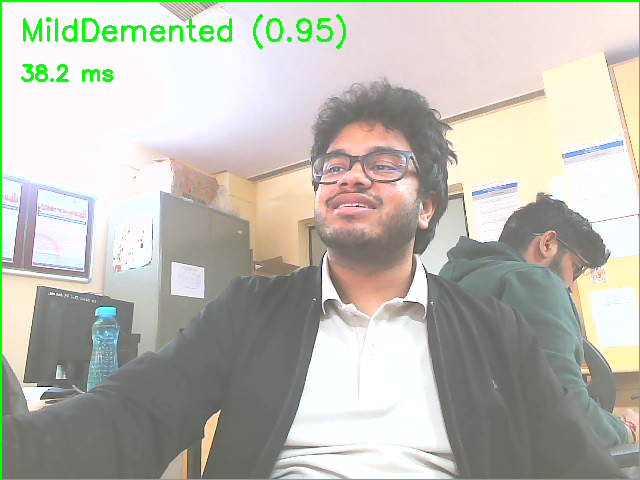

In [ ]:
from IPython.display import display, clear_output
from PIL import Image
import cv2, time

# =========================
# Kill any process using camera (important)
# =========================
!fuser -k /dev/video0

# =========================
# Camera setup (stable)
# =========================
cap = cv2.VideoCapture(0, cv2.CAP_V4L2)

# Force MJPEG (important for PYNQ)
cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*'MJPG'))

# Reduce resolution → faster and more stable
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

# Warm-up camera
time.sleep(2)

# Check camera
if not cap.isOpened():
    raise RuntimeError("Camera not detected. Restart kernel and run again.")

print("Real-time Alzheimer classification running...")
print("Click STOP in Jupyter to exit.")

try:
    while True:

        start = time.time()

        ret, frame = cap.read()

        # Retry once if frame fails
        if not ret:
            print("Frame error... retrying")
            time.sleep(0.5)
            ret, frame = cap.read()

            if not ret:
                print("Camera lost. Restart kernel.")
                break

        display_frame = frame.copy()

        # ===== MRI detection =====
        roi, box = crop_mri(frame)

        if roi is not None:

            # ===== Preprocess + FPGA =====
            ok = preprocess_from_frame(frame)

            if ok:
                label, confidence = run_dpu()

                # Draw bounding box
                x, y, w, h = box
                cv2.rectangle(display_frame, (x, y),
                              (x+w, y+h), (0, 255, 0), 2)

                latency = time.time() - start

                # Prediction text
                cv2.putText(display_frame,
                            f"{label} ({confidence:.2f})",
                            (20, 40),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            1,
                            (0, 255, 0),
                            2)

                # Latency text
                cv2.putText(display_frame,
                            f"{latency*1000:.1f} ms",
                            (20, 80),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            0.7,
                            (0, 255, 0),
                            2)

        # Convert BGR → RGB for Jupyter
        rgb = cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB)

        clear_output(wait=True)
        display(Image.fromarray(rgb))

        # Small delay → prevents crash
        time.sleep(0.01)

except KeyboardInterrupt:
    print("Stopped.")

finally:
    cap.release()

In [ ]:


import os
from collections import Counter

# ✅ IMPORTANT: Change this if your dataset location is different
test_root = "/home/xilinx/jupyter_notebooks/test"

folder_names = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
folder_to_class = dict(zip(folder_names, class_names))

max_total = 20   # limit for speed

y_true = []
y_pred = []
used_paths = []

count = 0

for folder in folder_names:
    folder_path = os.path.join(test_root, folder)

    if not os.path.exists(folder_path):
        print("Missing folder:", folder_path)
        continue

    for img_name in os.listdir(folder_path):

        if count >= max_total:
            break

        img_path = os.path.join(folder_path, img_name)

        pred_idx, pred_label = run_dpu_inference(img_path)

        if pred_label is None:
            continue

        true_label = folder_to_class[folder]

        y_true.append(true_label)
        y_pred.append(pred_label)
        used_paths.append(img_path)

        count += 1

print("Tested images:", len(y_true))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

num_classes = len(class_names)
cm = np.zeros((num_classes, num_classes), dtype=int)

name_to_idx = {name: i for i, name in enumerate(class_names)}

for t, p in zip(y_true, y_pred):
    i = name_to_idx[t]
    j = name_to_idx[p]
    cm[i, j] += 1

plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()

plt.xticks(range(num_classes), class_names, rotation=45)
plt.yticks(range(num_classes), class_names)

plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

In [17]:
correct_per_class = np.zeros(num_classes, dtype=int)
total_per_class = np.zeros(num_classes, dtype=int)

for t, p in zip(y_true, y_pred):
    i = name_to_idx[t]
    total_per_class[i] += 1
    if t == p:
        correct_per_class[i] += 1

acc_per_class = correct_per_class / np.maximum(total_per_class, 1)

print("Per-class accuracy:")
for name, acc in zip(class_names, acc_per_class):
    print(f"{name}: {acc*100:.2f}%")

Per-class accuracy:
Glioma: 60.00%
Meningioma: 60.00%
Notumor: 80.00%
Pituitary: 100.00%


In [18]:
correct = sum(t == p for t, p in zip(y_true, y_pred))
total = len(y_true)

overall_acc = correct / total if total > 0 else 0
print(f"Overall DPU accuracy: {overall_acc*100:.2f}% ({correct}/{total})")

Overall DPU accuracy: 75.00% (15/20)
